# Машинное обучение, DS-поток, осень 2024
## Задание ML.12


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.

**Баллы за задание**  
Задача 1 &mdash; **100 баллов**  
Задача 2 &mdash; **80 баллов**  

Всего &mdash; **180 баллов**  

In [4]:
# Утилиты стандартной библиотеки
from functools import lru_cache
import os
import glob

# Библиотеки для анализа данных
import numpy as np
import time
from collections import defaultdict
from IPython.display import clear_output
from tqdm.notebook import tqdm
from monai.losses import DiceLoss, TverskyLoss
import pandas as pd

# Библиотеки для обработки изображений
import cv2
from PIL import Image
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Библиотеки для обучения
import pytorch_lightning as pl
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torchmetrics import JaccardIndex
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from sklearn.model_selection import train_test_split

In [5]:
from pytorch_lightning.loggers import TensorBoardLogger

In [6]:
# Bot check

# HW_ID: ds_ml12
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

### Данные

Мы предлагаем вам поработать с подмножеством датасета [Carvana](https://www.kaggle.com/c/carvana-image-masking-challenge) с Kaggle. Carvana &mdash; это онлайн магазин подержаннных aвтомобилей. Компания организовала соревнование для того, чтобы получить модель, с помощью которой получилось бы автоматически сегментировать авто на фотографии. Затем, используя маску для автомобиля, его можно было использовать для получения более интересных фотографий с автомобилем.


Мы не будем использовать использовать датасет целиком, так как он очень большой, а для наших целей хватит небольшой его части.

Скачайте архив с даными [здесь](https://drive.google.com/file/d/1UbXOTP6GIp1pp-LwwpfX1p8m6iaWXzM1/view?usp=drive_link). Как работать со внешними данными на Google Colab или Kaggle описано в предыдущем домашнем задании.

In [7]:
zip_path = 'carvana.zip'
data_path = 'carvana'
#zip_path_bash = str(zip_path).replace(' ', '\ ')

In [8]:
#!unzip $zip_path_bash $data_path

Данные уже разделены на трейн и тест. В папках `train` и `train_masks` лежат изображения автомобилей и их маски соответственно. Аналогично для папок `test` и `test_masks`.

In [9]:
!ls $data_path

test  test_masks  train  train_masks


Изображения и маски имеют одинаковое начало названия. Название файла маски отличается тем, что есть окончание `_mask`, а также сам файл имеет другой формат &mdash; gif вместо jpg. Так можно получить изображение и его маску из трейна.


In [10]:
img_name = "0cdf5b5d0ce1_01.jpg"
splitted = img_name.split('.')
mask_name = splitted[0] + "_mask" + ".gif"

img_path = os.path.join(data_path, "train", img_name)
mask_path = os.path.join(data_path, "train_masks", mask_name)

Визуализируем изображение и маску.

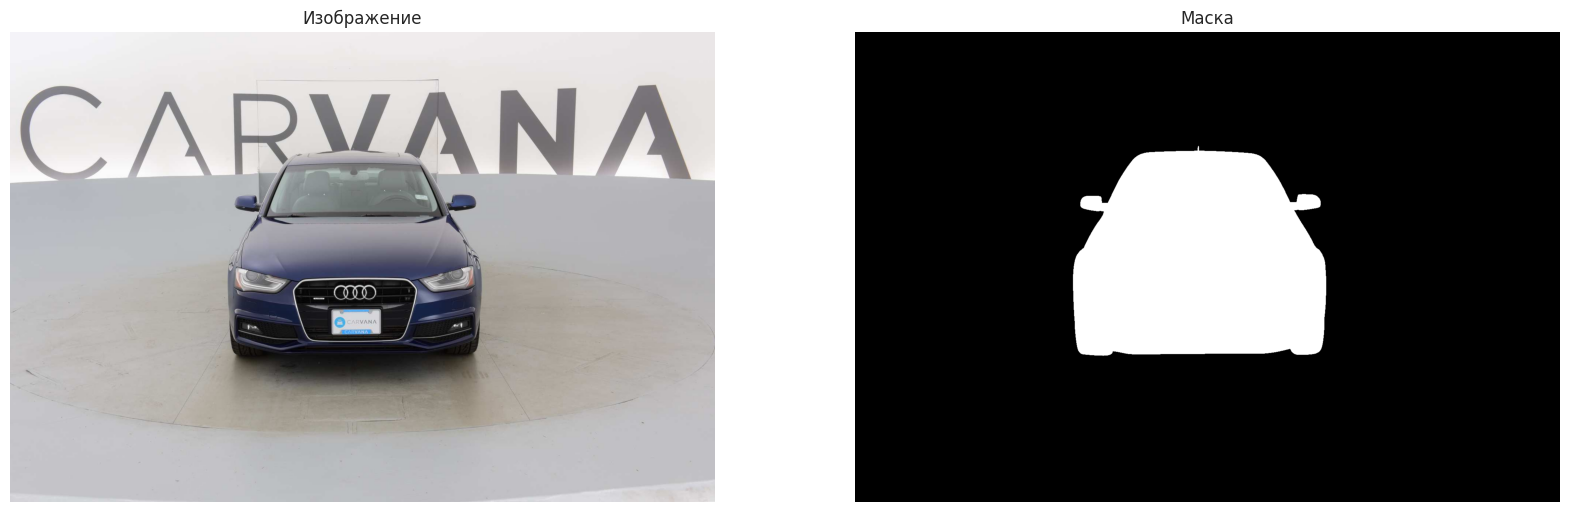

In [11]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(Image.open(img_path))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(Image.open(mask_path))
plt.axis("off");

Исходные изображения довольно большие. Предлагаем вам работать с изображениями меньшего размера, а именно (160, 240) для уменьшения вычислительных затрат. Не забудьте сделать соответствующее преобразование.

In [12]:
Image.open(img_path).size

(1918, 1280)

Во-первых, явно отметим, что с границей как на семинаре проблем нету

In [13]:
mask = Image.open('carvana/test_masks/00087a6bd4dc_15_mask.gif')

unique_values = np.unique(mask)

mask = np.array(mask)

print("Уникальные значения в маске:", unique_values)

Уникальные значения в маске: [0 1]


При этом 1 отвечает за красный, а 0 за синий

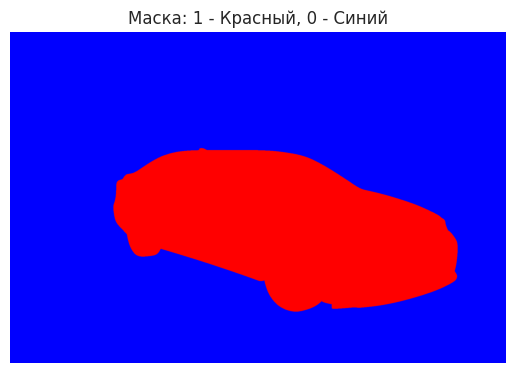

In [14]:
color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

color_mask[mask == 1] = [255, 0, 0]
color_mask[mask == 0] = [0, 0, 255]

plt.imshow(color_mask)
plt.axis('off')
plt.title("Маска: 1 - Красный, 0 - Синий")
plt.show()

Структура для работа с картинками

In [16]:
class CarvanaDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory,  transform=None):
        '''Задаем аугментации и пути к картинкам и маскам'''
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def _get_image_mask(self, image_filename):
        '''Получим картинку и маску для файла image_filename'''
        # Считываем изображение
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        if image is None:
            raise FileNotFoundError(f"Изображение по пути {mask_path} не найдено")
        # Упорядочиваем каналы в правильном порядке
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Считываем маску
        mask_filename = image_filename.split('.')[0] + "_mask.gif"
        mask_path = os.path.join(self.masks_directory, mask_filename)
        # mask = cv2.Image.open(mask_path, cv2.IMREAD_UNCHANGED)
        mask = np.array(Image.open(mask_path))
        #if mask is None:
        #    raise FileNotFoundError(f"Маска по пути {mask_path} не найдена")
        return image, mask

    def __getitem__(self, idx):
        '''Получим картинку и маску индекса idx'''
        image_filename = self.images_filenames[idx]
        image, mask = self._get_image_mask(image_filename)

        # Применяем трансформацию (аугментацию), если это необходимо
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask

Уменьшу размер и добавлю аугментации

In [17]:
train_transform = A.Compose(
    [
        A.Resize(160, 240),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.GaussNoise(),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ]
)
val_transform = A.Compose([
    A.Resize(160, 240),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

Теперь пути для всех трех частей (тренировочная, валидация, тест)

In [18]:
train_images_dir = os.path.join(data_path, "train")
train_masks_dir = os.path.join(data_path, "train_masks")
val_images_dir = os.path.join(data_path, "test")
val_masks_dir = os.path.join(data_path, "test_masks")

train_images_filenames = [f for f in os.listdir(train_images_dir) if f.endswith(".jpg")]
val_images_filenames = [f for f in os.listdir(val_images_dir) if f.endswith(".jpg")]

train_dataset = CarvanaDataset(train_images_filenames, train_images_dir,
                               train_masks_dir,
                               transform=train_transform)
val_dataset = CarvanaDataset(val_images_filenames, val_images_dir,
                             val_masks_dir,
                             transform=val_transform)

Даталоадеры

In [19]:
batch_size = 16
num_workers = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True)

### Задача 1. Простая сегментация
Вы построите свою собственную модель сегментации и проведете анализ ее работы.

#### 1. Обучение сегментации

Постройте модель типа U-Net. Вы можете использовать непосредственно первоначальную версию U-Net (рассматривали на лекции), либо ее модификацию, либо любую другую модель типа кодировщик-декодировщик с skip-connection конструкцией.

Класс модели

In [20]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16,
                                      name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(in_channels=features, out_channels=out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=features, out_channels=features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(features),
            nn.ReLU(inplace=True),
        )

Обучите модель на тренировочной части данных. В качестве метрики качества используйте IoU. Визуализируйте изменение ошибки (loss) и метрики (IoU) на тренировочной и тестовой части данных.

Инициализация модели, критерия и метрики

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

Функция-обучение модели:

In [22]:
def train(
        model,
        criterion,
        optimizer,
        scheduler,
        train_loader,
        val_loader,
        num_epochs,
        device,
        checkpoint_path=None,
):
    """
    # Обучение модели
    """
    start_time = time.time()
    scheduler.step()
    history = defaultdict(lambda: defaultdict(list))
    best_val_iou = 0.
    train_iou_metric = JaccardIndex(task="binary", num_classes=2).to(device)
    val_iou_metric = JaccardIndex(task="binary", num_classes=2).to(device)
    model.to(device)

    for epoch in range(num_epochs):
        train_loss = 0
        train_iou = 0
        val_loss = 0
        val_iou = 0
        train_size, val_size = 0, 0

        model.train()  # устанавливаем поведение dropout / batch_norm  в обучение

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in tqdm(train_loader):
            y_batch = y_batch.long()
            X_batch, y_batch = X_batch.to(device, non_blocking=True),\
            y_batch.to(device, non_blocking=True)

            # Обучаемся на батче (одна "итерация" обучения нейросети)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            y_pred = torch.argmax(logits, dim=1)
            batch_iou = train_iou_metric(y_pred, y_batch).item()

            history['loss']['train_batch'].append(loss.item())
            history['iou']['train_batch'].append(batch_iou)

            train_loss += loss.item() * len(y_batch)
            train_size += len(y_batch)
        
        # Подсчитываем лоссы и точность, сохраням в "историю"
        train_loss /= train_size
        history['loss']['train'].append(train_loss)

        # Устанавливаем поведение dropout / batch_norm  в тестирование
        model.eval()

        # Полный проход по валидации
        with torch.no_grad():
            for X_batch, y_batch in tqdm(val_loader):
                y_batch = y_batch.long()
                X_batch, y_batch = X_batch.to(device, non_blocking=True),\
                y_batch.to(device, non_blocking=True)
                logits = model(X_batch)
                loss = criterion(logits, y_batch)

                val_loss += loss.item() * len(y_batch)
                y_pred = torch.argmax(logits, dim=1)
                val_iou_metric.update(y_pred, y_batch) 
                
                history['loss']['val_batch'].append(loss.item())

                val_loss += loss.item() * len(y_batch)
                val_size += len(y_batch)

        val_loss /= val_size
        val_iou = val_iou_metric.compute().item()
        val_iou_metric.reset()
        history['loss']['val'].append(val_loss)
        history['iou']['val'].append(val_iou)

        if (checkpoint_path is not None) and (val_iou > best_val_iou):
            torch.save({
                'model': model.state_dict(),
                'optim': optimizer.state_dict(),
                }, checkpoint_path)
            best_val_iou = val_iou

        clear_output()
        # Печатаем результаты после каждой эпохи
        print(f"Epoch {epoch + 1}/{num_epochs}. Time elapsed: {time.time() - start_time:.2f}s")
        print(f"  Train Loss: {train_loss:.4f} | Train IoU: {train_iou:.4f}")
        print(f"  Val Loss: {val_loss:.4f} | Val IoU: {val_iou:.4f}")

    return history

Осталось обучить

In [23]:
num_epochs = 1
history = train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs,
    device=device,
    checkpoint_path="unet.pth"
)

Epoch 1/1. Time elapsed: 90.30s
  Train Loss: 0.3899 | Train IoU: 0.0000
  Val Loss: 0.6639 | Val IoU: 0.9487


Функция для отрисовки обучения

In [24]:
def plot_histories(histories, names):
    sns.set_style('darkgrid')
    colors = ['darkblue', 'lightcoral', 'limegreen', 'sandybrown',
              'gold', 'orchid', 'teal', 'coral', 'skyblue']

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title('Лосс')
        axs[0].plot(history['loss']['train_batch'][:len(history['loss']['train_batch'])],
                    label=f'{name} Train Loss (Побатчево)', lw=1.5, c=colors[i])
        axs[0].set_xlabel('Batch')
        axs[0].set_ylabel('Loss')

        axs[1].set_title('IoU')
        axs[1].plot(history['iou']['train_batch'][:len(history['iou']['train_batch'])],
                    label=f'{name} Train IoU (Побатчево)', lw=1.5, c=colors[i])
        axs[1].set_xlabel('Batch')
        axs[1].set_ylabel('IoU')

        val_loss_mean = history['loss']['val'][-1]
        val_iou_mean = history['iou']['val'][-1]

        axs[0].axhline(val_loss_mean, color=colors[i+5],
                       linestyle='--', lw=2, label=f'{name} Val Loss (Среднее)')

        axs[1].axhline(val_iou_mean, color=colors[i+5],
                       linestyle='--', lw=2, label=f'{name} Val IoU (Среднее)')

        axs[0].legend()
        axs[1].legend()

    plt.tight_layout()
    plt.show()


Модель обучается очень быстро, за одну эпоху. Поэтому построим график обучения на одной эпохе побатчево. Для сравнения лосс и метрика на валидационной выборке посчитаны в среднем.

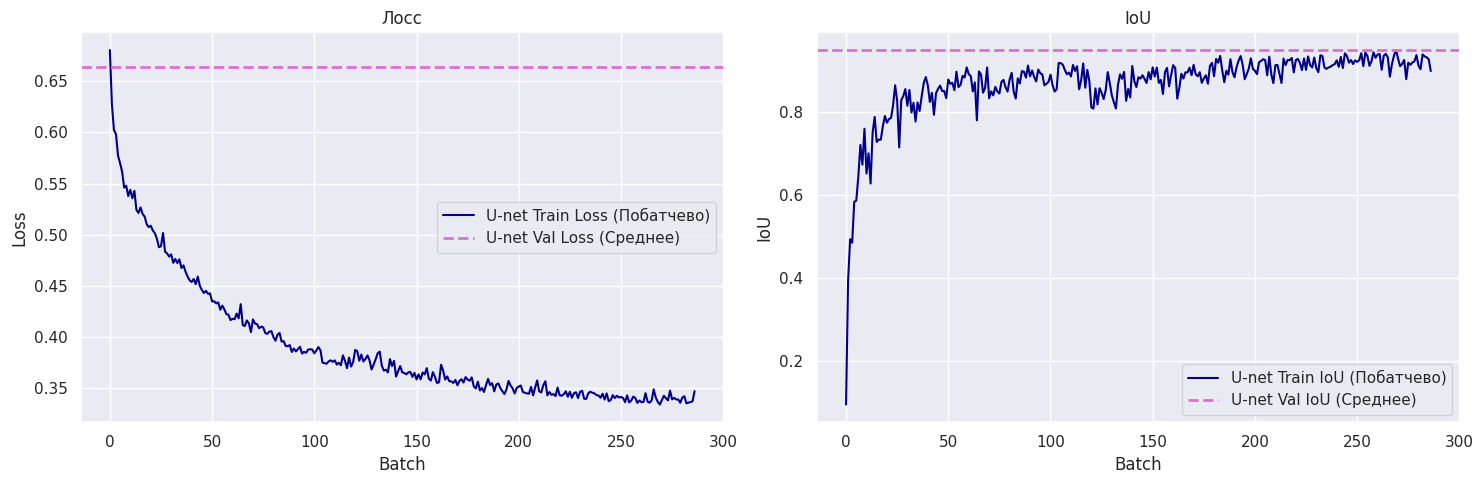

In [25]:
plot_histories([history], ['U-net'])

Как быстро обучается модель? Как вы думаете, с чем это связано?

**Ответ:** 
Модель обучается очень быстро, за одну эпоху, она очень хорошо справляется с этой задачей. Автомобили в изображениях легко различимы

#### 2. Анализ модели
Выберите 10 изображений из тестовой части данных и посчитайте качество модели на них. Теперь поменяйте фон для изображений. Можно, например, поменять его цвет. Проверьте качество модели на новых изображениях.

Вспомогательная функция

In [40]:
def outputs_to_probs(model_outputs, mode='softmax'):
    """
    Предсказания нужно отмасштабировать, чтобы получить ~ вероятности
    """
    assert mode in ('softmax', 'minmax')
    if mode == "softmax":
        category_probs = torch.softmax(model_outputs, dim=0).numpy()
    elif mode == 'minmax':
        category_preds = model_outputs.numpy()
        category_probs = sklearn.preprocessing.MinMaxScaler()\
                        .fit_transform(np.ravel(category_preds)[:, None])\
                        .reshape(category_preds.shape)
    else:
        raise NotImplementedError("This mode is not impleted. Use one of ('softmax', 'minmax').")
    return category_probs

def plot_probs(image, probs, mask):
    '''Визуализирует исходное изображение, предсказания для класса и цветную маску'''
    sns.set(font_scale=0.9)
    plt.figure(figsize=(12, 16))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Исходное изображение')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    try:
        plt.imshow(probs[1], cmap='viridis')
    except:
        plt.imshow(probs[0], cmap='viridis')
    plt.title('Предсказания')
    plt.colorbar(fraction=0.03, pad=0.04)
    plt.axis('off')

    mask = np.array(mask)
    color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    color_mask[mask == 1] = [255, 255, 255]
    color_mask[mask == 0] = [0, 0, 0]

    plt.subplot(1, 3, 3)
    plt.imshow(color_mask)
    plt.title('Истинная маска')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Убираем нормализацию

In [41]:
def reverse_normalization(img, mean, std):
    """
    Выполняет обратную нормализацию изображения.
    """
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)

    img = img * std + mean
    img = img * 255

    return img.clamp(0, 255).byte() 

Визуализация на тесте

<Figure size 1500x1500 with 0 Axes>

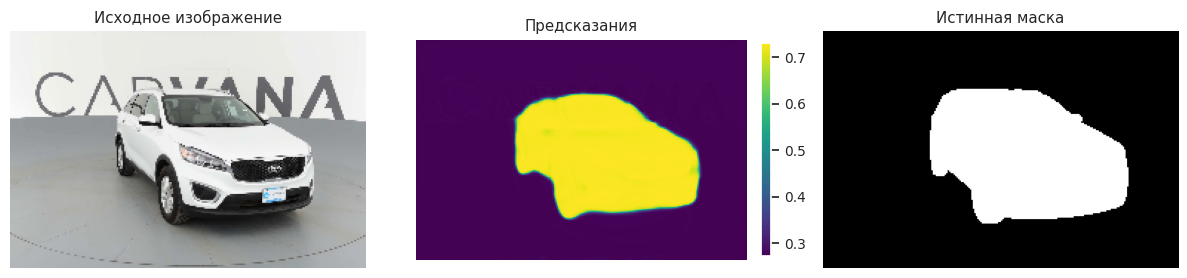

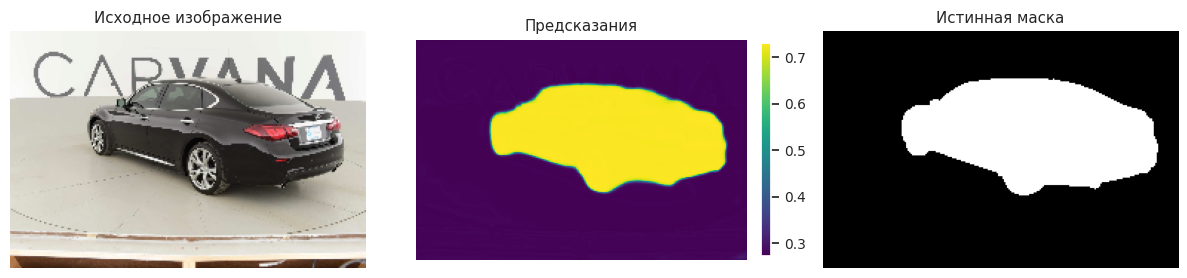

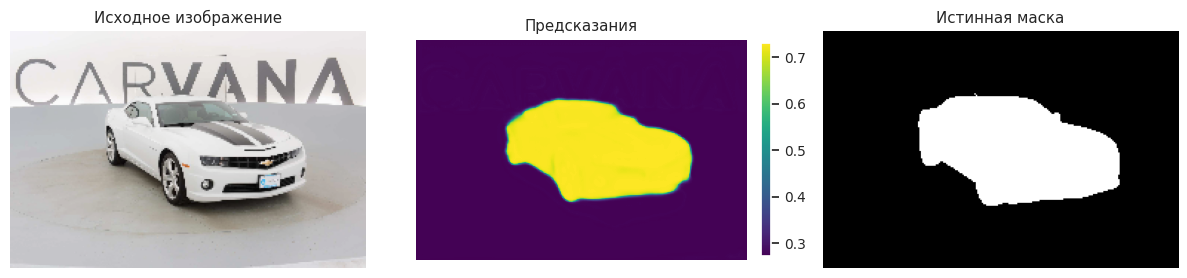

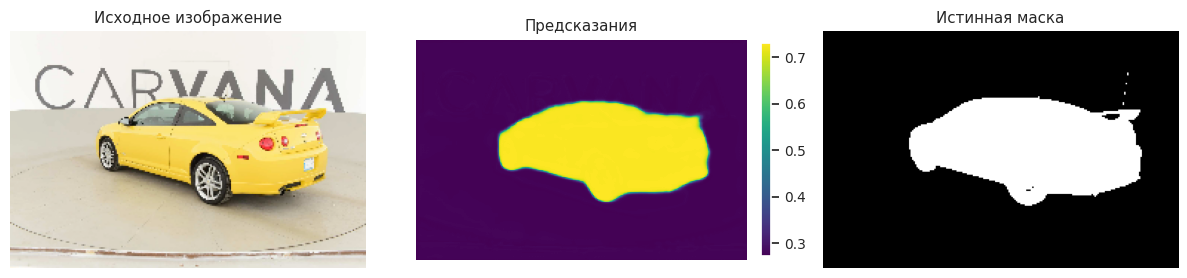

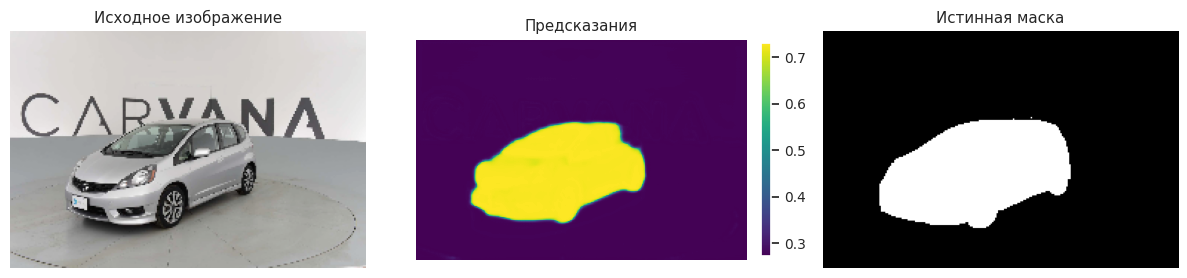

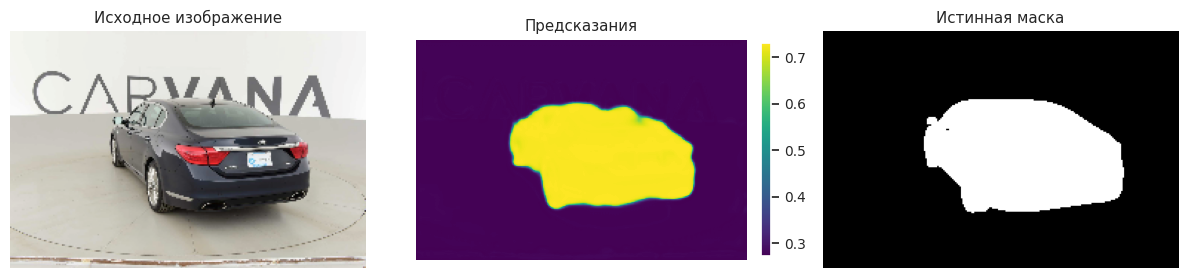

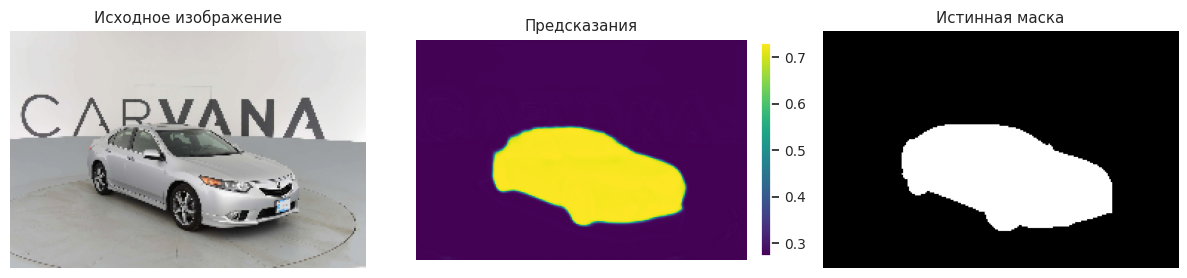

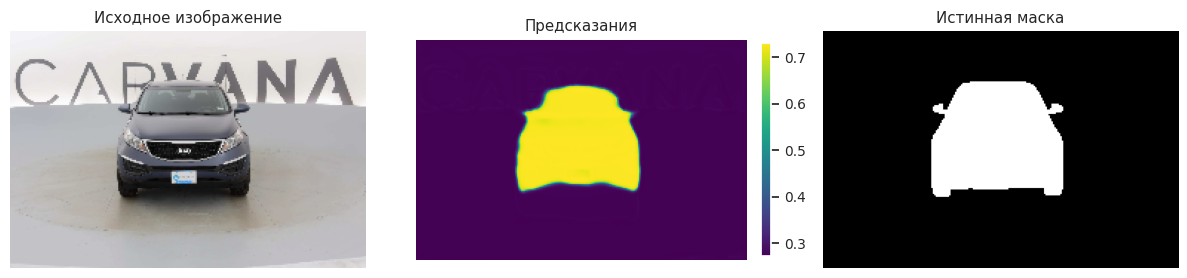

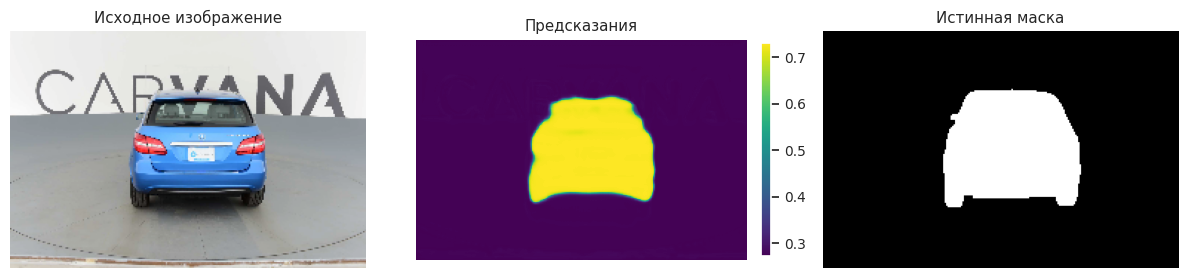

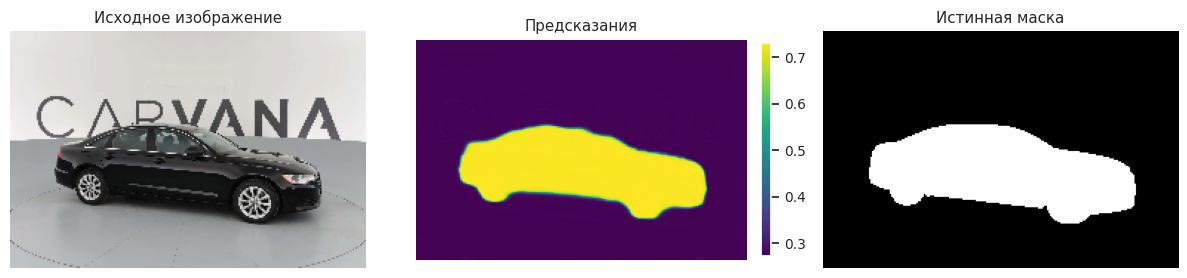

In [42]:
indices = np.random.choice(len(val_dataset), size=10, replace=False)

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

plt.figure(figsize=(15, 15))

for i, idx in enumerate(indices):
    image, mask = val_dataset[idx]
    image = image.to(device)
    with torch.no_grad():
        outputs = model.forward(image.unsqueeze(0)).cpu().squeeze()
    image = image.to('cpu')
    img_restored = reverse_normalization(image, mean, std)
    img_restored = img_restored.permute(1, 2, 0).numpy()
    plot_probs(img_restored, outputs_to_probs(outputs, mode='softmax'), mask)

Теперь заменим белый фон

In [52]:
def change_background(image, mask, new_color=(0.3, 0.8, 1)):
    """
    Заменяет фон изображения на новый цвет.
    """
    new_color_tensor = torch.tensor(new_color).float()

    for c in range(image.shape[0]):
        image[c][mask == 0] = new_color_tensor[c]

    return image

Визуализация

<Figure size 1500x1500 with 0 Axes>

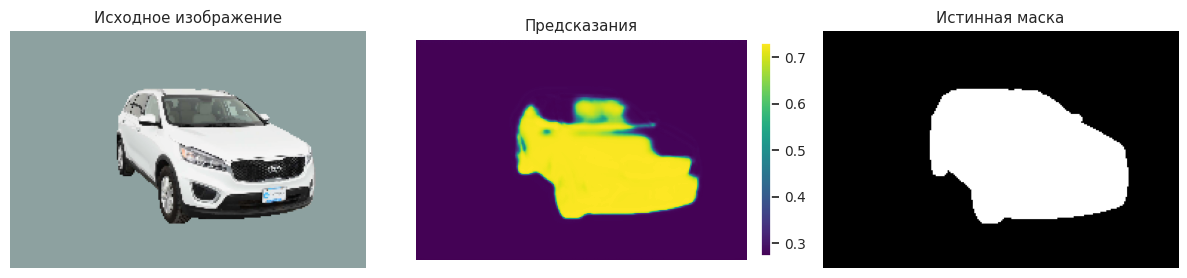

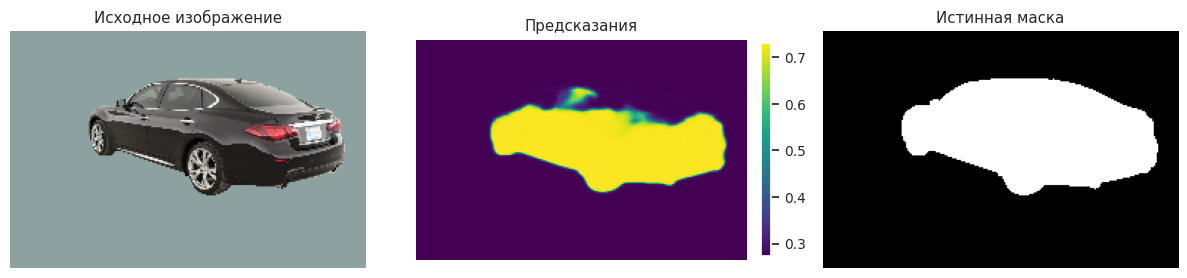

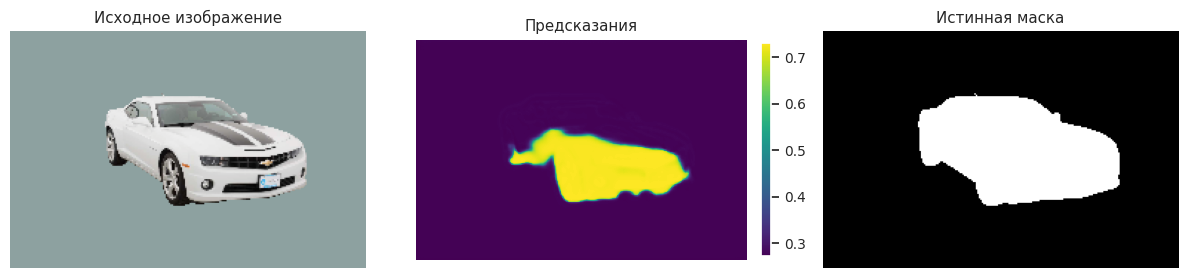

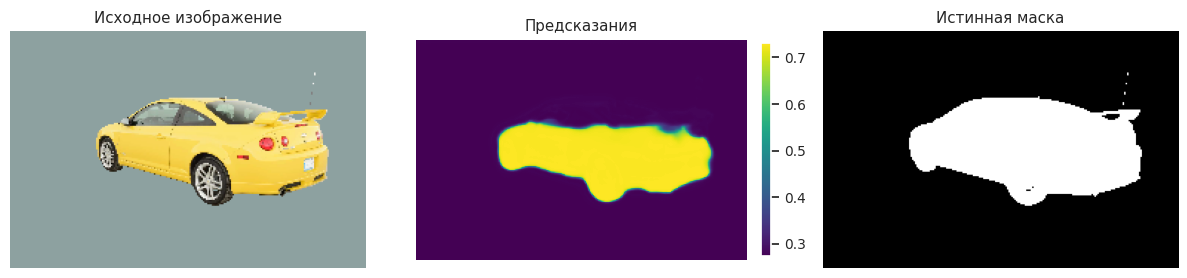

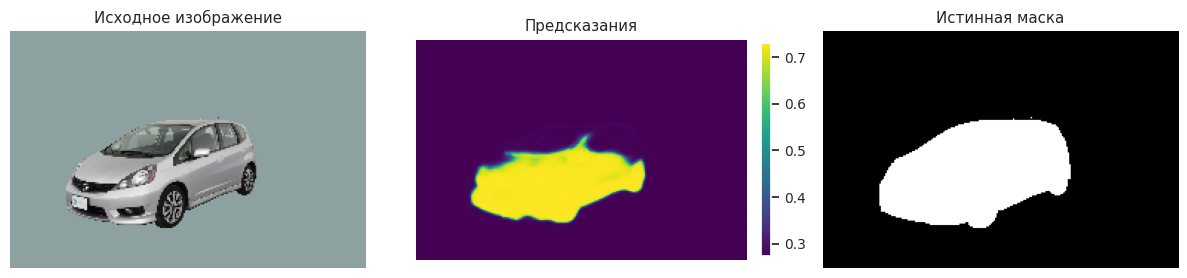

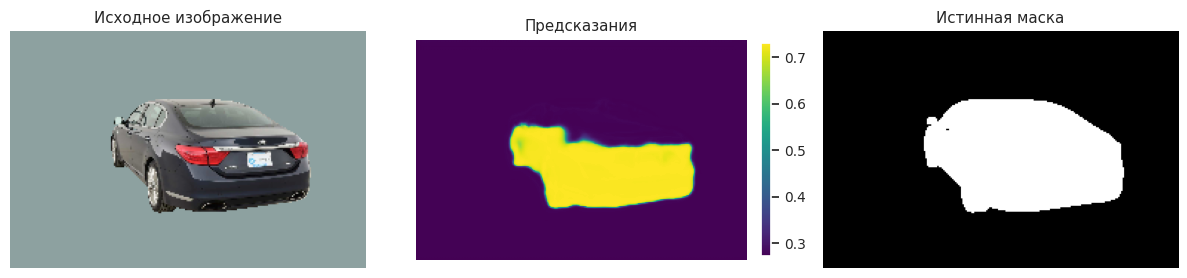

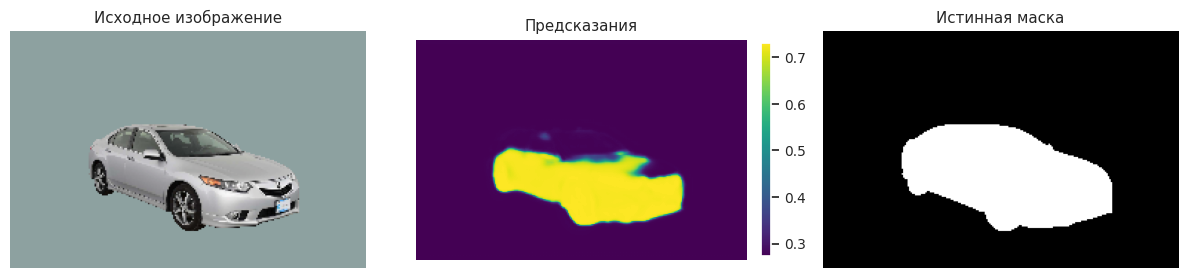

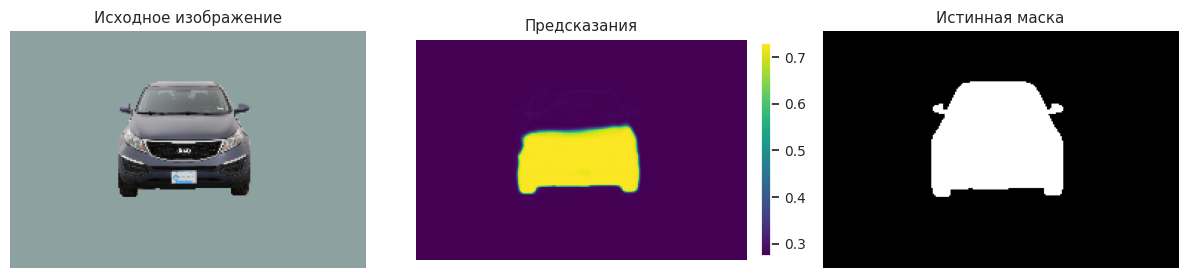

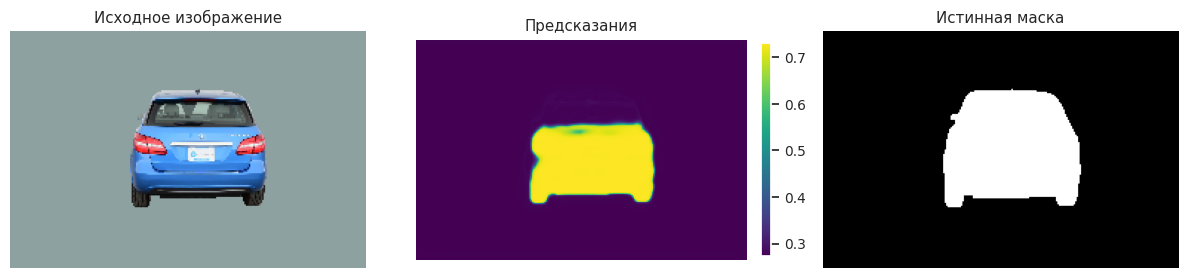

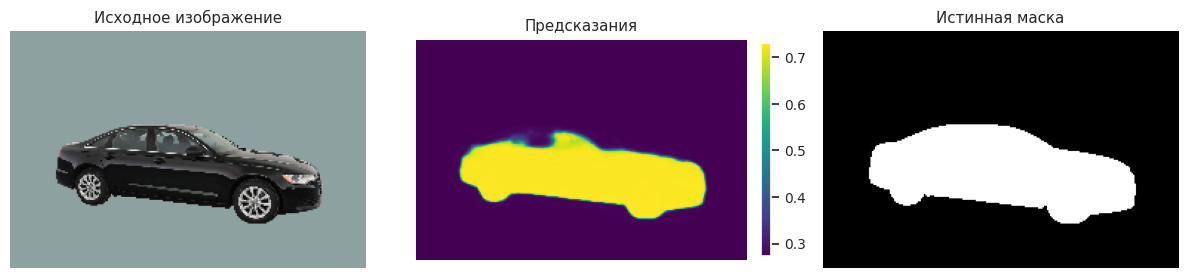

In [53]:
plt.figure(figsize=(15, 15))

for i, idx in enumerate(indices):
    image, mask = val_dataset[idx]
    image = change_background(image, mask)
    image = image.to(device)
    with torch.no_grad():
        outputs = model.forward(image.unsqueeze(0)).cpu().squeeze()
    image = image.to('cpu')
    img_restored = reverse_normalization(image, mean, std)
    img_restored = img_restored.permute(1, 2, 0).numpy()
    plot_probs(img_restored, outputs_to_probs(outputs, mode='softmax'), mask)

Ответьте на вопрос, модель научилась сегментировать машины или фон?

**Ответ:** 

Мы в лоб попробовали убрать фон (просто заменив белые цвета на серые), на части изображений получилось хорошо отдалить машину. Модель отличает букмы CARVANA от самой машины; но с таким фоном она уже хуже сегментирует машину

Но она все таки сегментирует фон - потому что она не умеет различать машину от любых других объектов. Например, посмотрим, что она даст на картинках с мышами

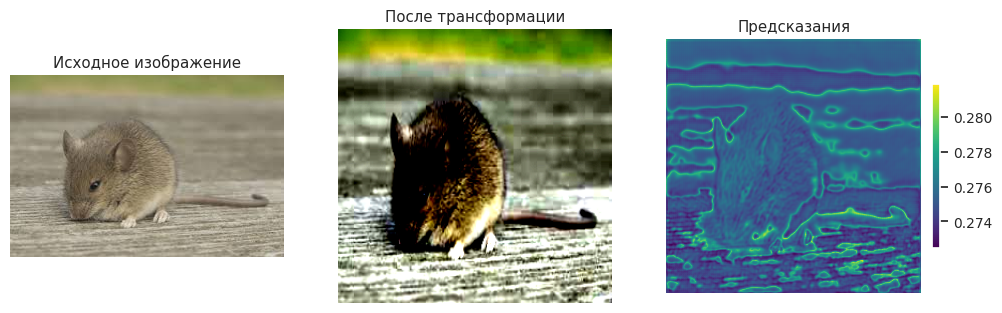

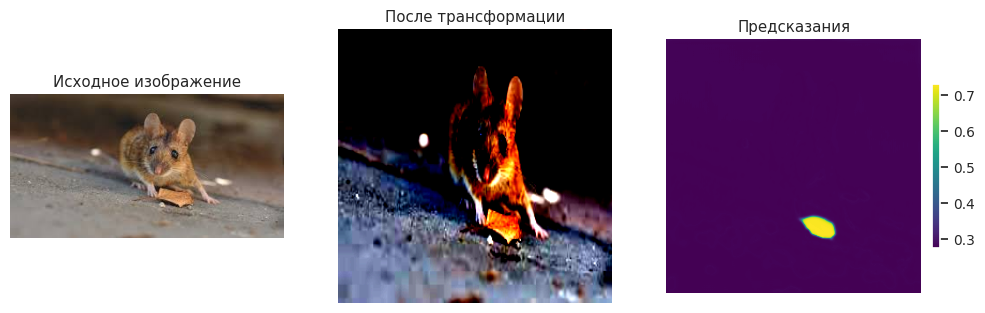

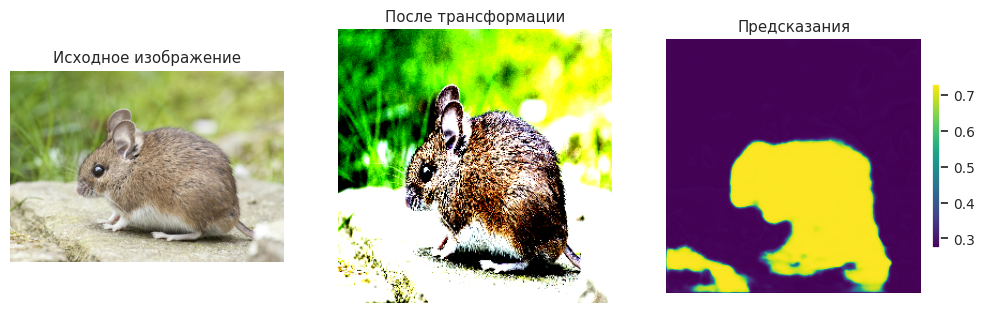

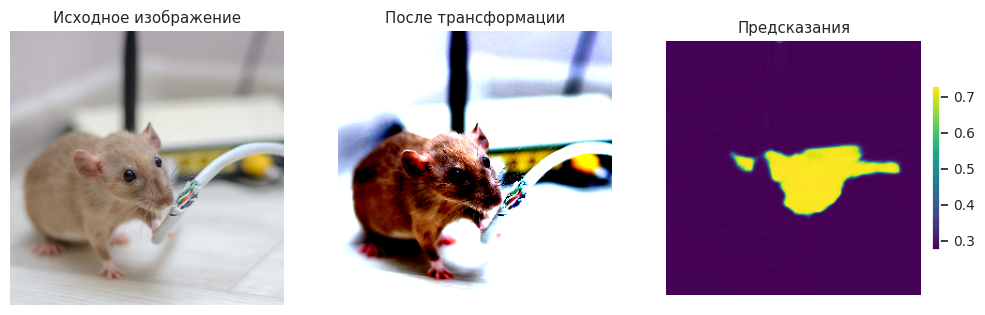

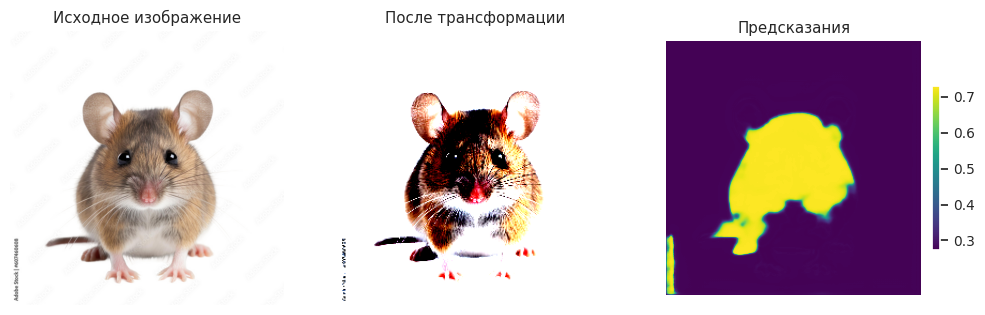

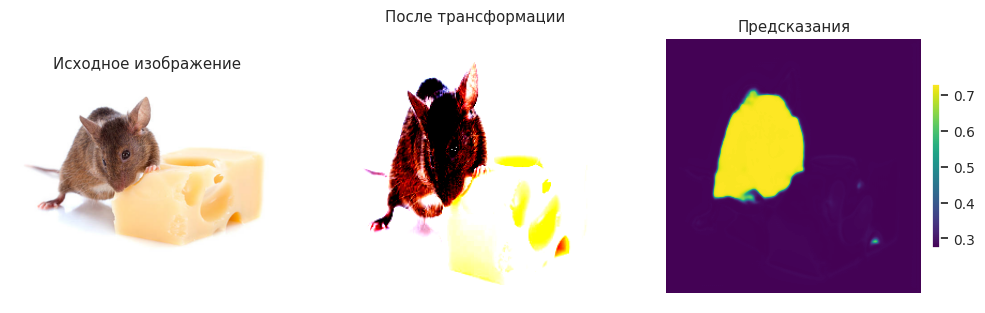

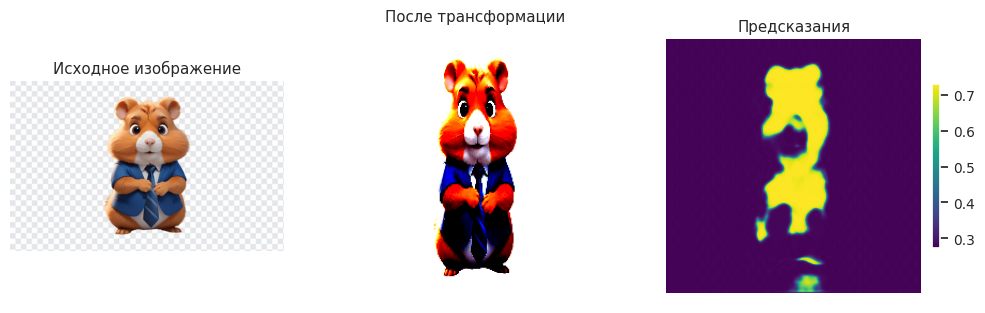

In [30]:
mouse_dir = os.path.join('mouse')
mouse_images_filenames = [f for f in os.listdir(mouse_dir) if f.endswith(".jpg")]

transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

for image_filename in mouse_images_filenames:
    image_path = os.path.join(mouse_dir, image_filename)
    image_first = cv2.imread(image_path)
    
    image_first = cv2.cvtColor(image_first, cv2.COLOR_BGR2RGB)
    image_tensor = transform(image=image_first)['image']
    image_tensor = image_tensor.unsqueeze(0).to('cuda')
    
    with torch.no_grad():
        outputs = model(image_tensor).cpu().squeeze()
    category_probs = torch.softmax(outputs, dim=0).numpy()
    image = image_tensor.squeeze().cpu().numpy().transpose(1, 2, 0) 

    sns.set(font_scale=0.9)
    plt.figure(figsize=(12, 16))

    plt.subplot(1, 3, 1)
    plt.imshow(image_first)
    plt.title('Исходное изображение')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.title('После трансформации')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(category_probs[1], cmap='viridis')
    plt.title('Предсказания')
    plt.colorbar(fraction=0.03, pad=0.04)
    plt.axis('off')

Откуда видно что все таки она сегментирует именно фон, причем не всегда правильно

**Вывод:**

Модель U-Net несложная и при этом дает хорошую точность в сегментации таких картинок

### Задача 2. Сравнение лоссов сегментации
Будем работать с датасетом [CityScapes](https://www.cityscapes-dataset.com/). Этот датасет состоит из кадров съемки автомобиля, движущегося по улицам  Германии. Проверим, насколько хорошо с ним справляются предобученные модели со структурой, отличной от U-Net. Скачайте [архив](https://disk.yandex.ru/d/J8gPv_bEiK-_QQ) с данными с диска. В папках `images` и `masks` лежат изображения и маски автомобилей соответственно.



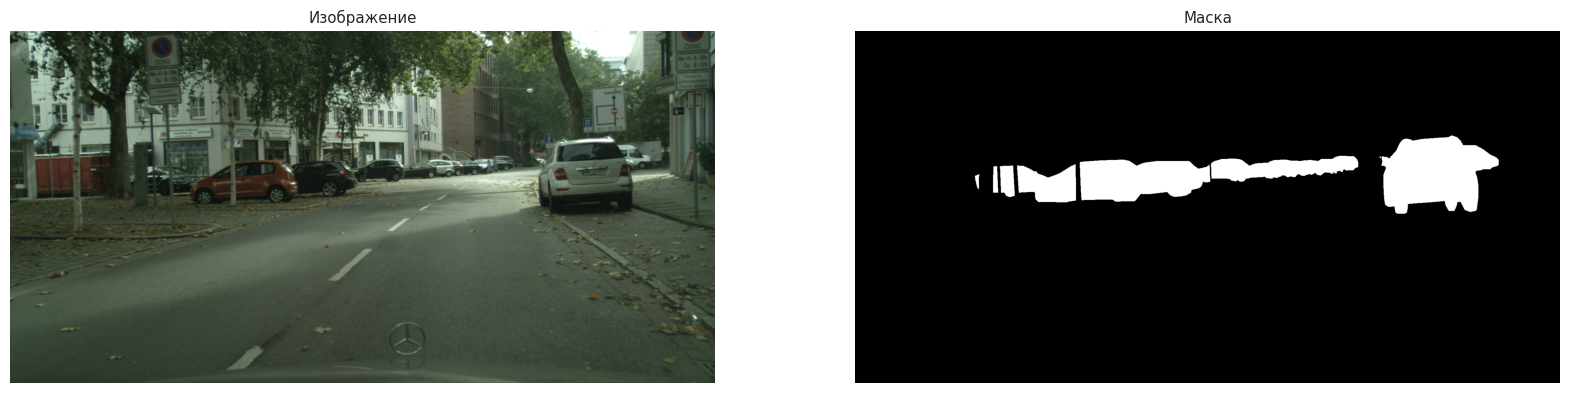

In [31]:
data_path = 'cityscapes'
img_name = "bremen_000061_000019.png"
splitted = img_name.split('.')
mask_name = splitted[0] + "_mask" + ".png"

img_path = os.path.join(data_path, "images", img_name)
mask_path = os.path.join(data_path, "masks", mask_name)
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.title("Изображение")
plt.imshow(Image.open(img_path))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(Image.open(mask_path))
plt.axis("off");

Определите датасет для CityScapes и даталоадеры.

In [15]:
class CityScapesDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory,  transform=None):
        '''Задаем аугментации и пути к картинкам и маскам'''
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)


    @lru_cache(maxsize=None)
    def _get_image_mask(self, image_filename):
        '''Получим картинку и маску для файла image_filename'''
        image = np.array(Image.open(os.path.join(self.images_directory, image_filename))).astype(np.uint8)
        mask_filename = image_filename.split('.')[0] + "_mask.png"
        mask = np.array(Image.open(os.path.join(self.masks_directory, mask_filename))).astype(np.uint8)
        return image, mask

    def __getitem__(self, idx):
        '''Получим картинку и маску индекса idx'''
        image_filename = self.images_filenames[idx]
        image, mask = self._get_image_mask(image_filename)

        # Применяем трансформацию (аугментацию), если это необходимо
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]

        return image, mask

Трансформации оставлю теми же, осталось создать датасеты

In [16]:
images_dir = os.path.join(data_path, "images")
masks_dir = os.path.join(data_path, "masks")

images_filenames = [f for f in os.listdir(images_dir) if f.endswith(".png")]

train_filenames, val_filenames = train_test_split(images_filenames,
                                                  test_size=0.2,
                                                  random_state=42)


train_dataset = CityScapesDataset(train_filenames, images_dir,
                                   masks_dir,
                                   transform=train_transform)

val_dataset = CityScapesDataset(val_filenames, images_dir,
                                 masks_dir,
                                 transform=val_transform)

Даталоадеры

In [17]:
batch_size = 16
num_workers = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True)

Определите класс модуля lightning для обучения модели сегментации машин. В качестве модели используйте предобученную `fcn_resnet50` или `deeplabv3_resnet50` из `torchvision.models.segmentation` на ваш выбор. Особенностью их использования является то, что модели дают на выходе маски для 21 класса (как в COCO) в поле `out` (см. примеры в семинаре). В остальном модели не отличаются от тех, что мы использовали ранее.

Наша цель - сравнить работу 3 лоссов - Binary Cross Entropy, Dice Loss, Tversky Loss. Реализацию двух последних можно взять из библиотеки [monai](https://docs.monai.io/en/stable/losses.html).

В качестве метрики используйте IoU.

Определяем класс модели для дообучения модели

In [70]:
class SegmentationModel(pl.LightningModule):
    def __init__(self, loss, lr=1e-4, alpha=None, beta=None):
        '''Инициализация модели, двуклассовая сегментация'''
        super().__init__()
        self.lr = lr
        if loss == 'bce':
            self.criterion = nn.BCEWithLogitsLoss()
        elif loss == 'dice':
            self.criterion = DiceLoss()
        elif loss == 'tversky':
            self.criterion = TverskyLoss(alpha=alpha, beta=beta)
    
        self.model = models.segmentation.fcn_resnet50(device='cuda', weights='DEFAULT')
        self.iou = JaccardIndex(task='binary', num_classes=2, ignore_index=0)
        self.predictions = []
        self.save_hyperparameters()

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

    def forward_all_classes(self, x):
        '''Предсказание для всех 21 каналов'''
        return self.model(x)['out'] # (BS, 21, H, W)

    def forward(self, x):
        '''Предсказание только для канала машины'''
        return self.forward_all_classes(x)[:, 7] # (BS, H, W)

    def __step(self, batch, stage):
        '''Возвращает лосс с 1 шага обучения по батчу'''
        images, target = batch
        output = self.forward(images)
        #probs = torch.softmax(output, dim=1)
        
        loss = self.criterion(output.float(), target.float())
        
        iou = self.iou(output, target.int()) 

        self.log(f'{stage}_loss', loss, on_step=True, prog_bar=True)
        self.log(f'{stage}_iou', iou, on_step=True, prog_bar=True)
        
        return loss

    def training_step(self, batch, batch_idx):
        return self.__step(batch, 'train')

    def validation_step(self, batch, batch_idx):
        return self.__step(batch, 'val')

    def test_step(self, batch, batch_idx):
        '''Сохраняет предсказанную маску сегментации в self.predictions'''
        images, (original_heights, original_widths) = batch
        output = self.forward(images)
        probabilities = torch.softmax(output, dim=1)
        #(probabilities[:, 1] >= 0.5).float()
        #predicted_masks = (probabilities >= 0.5).float()
        predicted_masks = predicted_masks.cpu().numpy()
        for predicted_mask, original_height, original_width in zip(
            predicted_masks, original_heights.cpu().numpy(), original_widths.cpu().numpy()
        ):
            self.predictions.append((predicted_mask, original_height, original_width))

#### Визуализация до обучения

До обучения визуализируйте несколько предсказаний модели на тестовой части CityScapes. Покажите исходную картинку, предсказание модели и истинную маску. Не забудьте брать предсказания только по каналу машин.

In [19]:
def visualize_predictions(image, true_mask, predicted_mask):
    """
    Функция для визуализации исходного изображения, истинной маски и предсказанной маски.
    
    """
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(image)
    ax[0].set_title("Исходное изображение")
    ax[0].axis('off')

    ax[1].imshow(true_mask, cmap='gray')
    ax[1].set_title("Истинная маска")
    ax[1].axis('off')

    im = ax[2].imshow(predicted_mask, cmap='viridis')
    ax[2].set_title("Предсказание модели (softmax)")
    ax[2].axis('off')

    fig.colorbar(im, ax=ax[2], fraction=0.03, pad=0.04)

    plt.show()

def reverse_normalization(img, mean, std):
    """
    Выполняет обратную нормализацию изображения.
    """
    mean = torch.tensor(mean).view(-1, 1, 1)
    std = torch.tensor(std).view(-1, 1, 1)

    img = img * std + mean
    img = img * 255

    return img.clamp(0, 255).byte() 

Сама отрисовка

/home/juequ/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/juequ/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=FCN_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


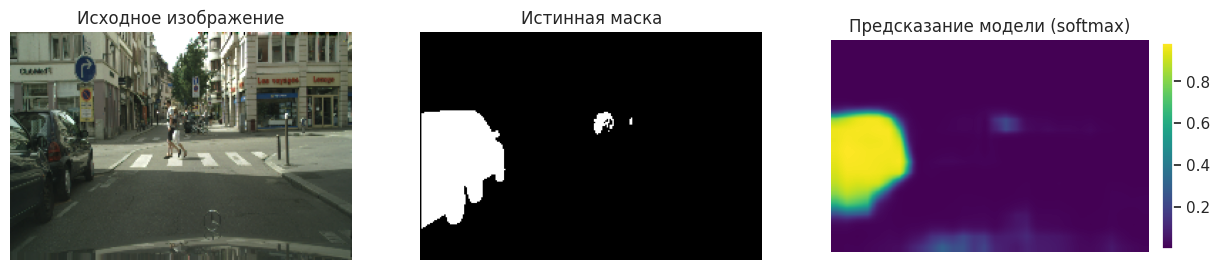

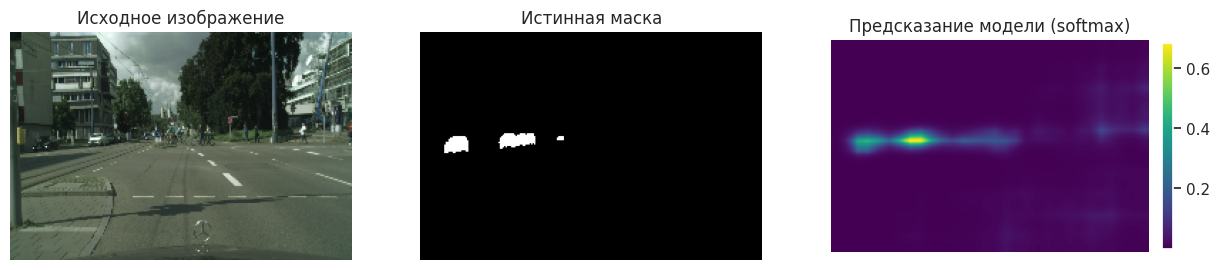

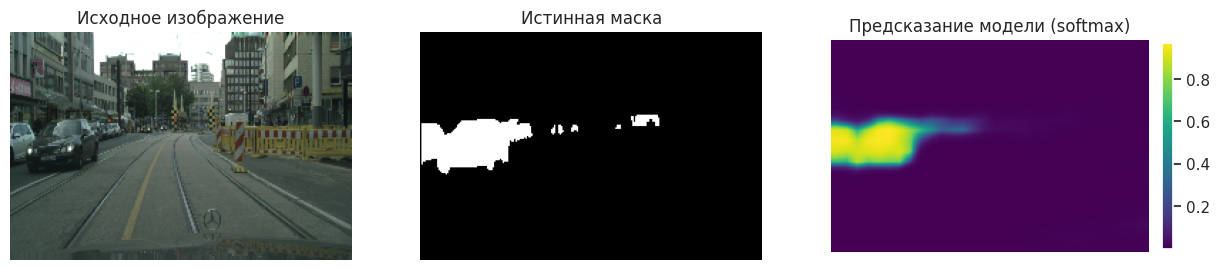

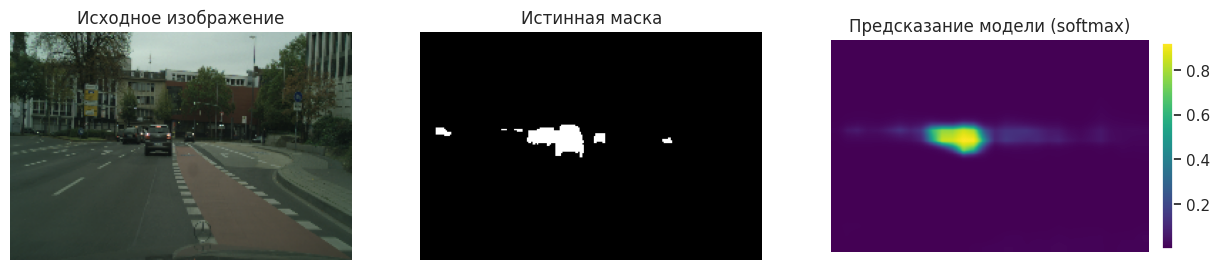

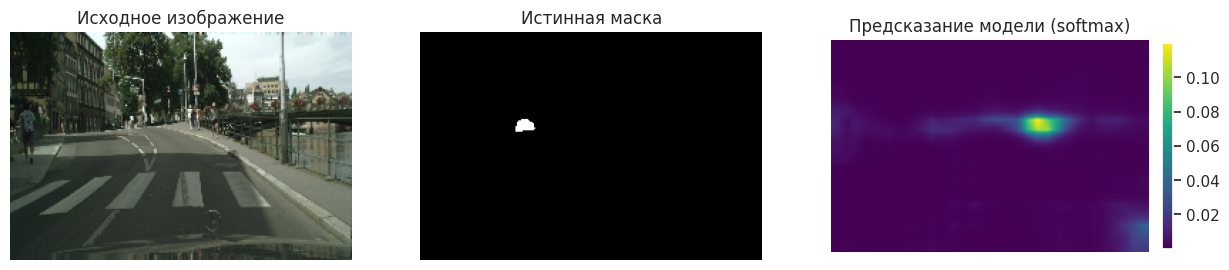

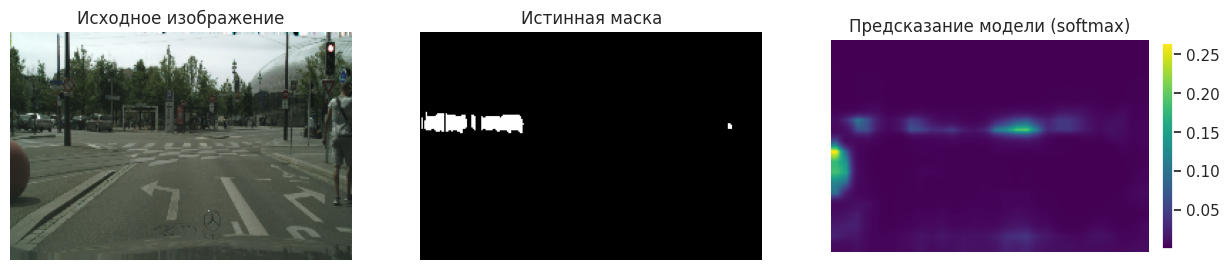

In [20]:
model = models.segmentation.fcn_resnet50(pretrained=True).to('cuda')

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
model.eval()

with torch.no_grad():
    for batch_idx, (images, true_masks) in enumerate(val_loader):
        images = images.to('cuda')
        true_masks = true_masks.to('cuda')

        outputs = model(images)['out'] 
        pred_logits = outputs
        pred_probs = torch.softmax(pred_logits, dim=1)

        for idx in range(images.size(0)):
            if idx > 5:
                break
            img_restored = reverse_normalization(images[idx].cpu(), mean, std)
            img_restored = img_restored.permute(1, 2, 0).numpy()

            true_car_mask = true_masks[idx].cpu().numpy()
            pred_car_probs = pred_probs[idx, 7].cpu().numpy()

            visualize_predictions(img_restored, true_car_mask, pred_car_probs)
        break

Видно, что точности не хватает - нужно дообучать модель

#### Binary Cross Entropy

Обучите предобученную модель, используя BCE Loss. Сравните несколько предсказаний с истинными масками на тестовой выборке. Также после обучения (до завершения wandb run) выведите IoU на тесте с помощью `trainer.validate`.

Логгер

In [21]:
import wandb
from pytorch_lightning.loggers import WandbLogger

sns.set(style='darkgrid', palette='Set2')
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ermolaevfedor (juequ). Use `wandb login --relogin` to force relogin


True

Обучение

In [42]:
fcn_bce = SegmentationModel(loss='bce')
wandb_logger = WandbLogger(project='segment_classification', log_model='none')
trainer = pl.Trainer(max_epochs=20,
                     logger=wandb_logger,
                     log_every_n_steps=1)

trainer.fit(fcn_bce, train_loader, val_loader)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | criterion | BCEWithLogitsLoss  | 0      | train
1 | model     | FCN                | 35.3 M | train
2 | iou       | BinaryJaccardIndex | 0      | train
---------------------------------------------------------
35.3 M    Trainable params
0         Non-trainable params
35.3 M    Total params
141.289   Total estimated model params size (MB)
164       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=20` reached.


Метрика

In [119]:
metrics_df.head(1)

Модель  Максимум val_iou_epoch  Минимум val_loss_epoch
0  FCN_ResNet50 (bce)                   0.903                  0.0451

Графики

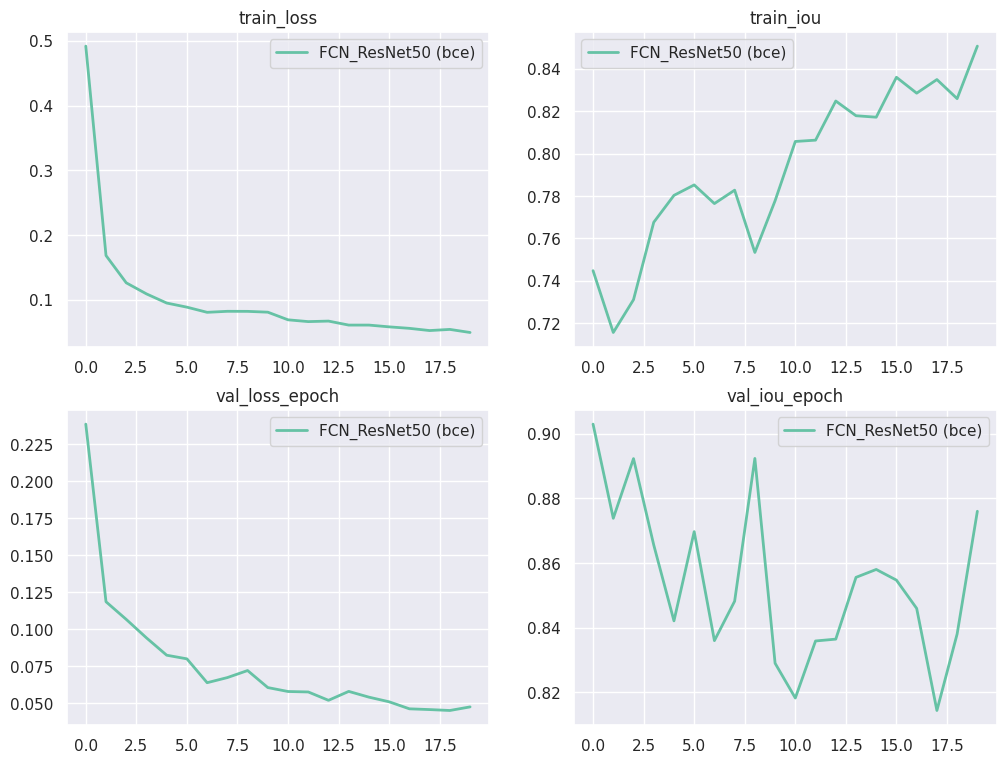

In [79]:
runs = wandb.Api().runs("segment_classification")
subplot_names = np.array([['train_loss', 'train_iou'],
                          ['val_loss_epoch', 'val_iou_epoch']])

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
lw = 2
for i, run in enumerate(runs):
    if 'bce' not in run.name:
        continue
        
    df = run.history().groupby('epoch').mean(numeric_only=True)
    for k in range(2):
        for m in range(2):
            axs[k, m].set_title(subplot_names[k, m])
            axs[k, m].plot(df[subplot_names[k, m]], lw=lw, label=run.name)
            axs[k, m].legend()


#### Dice Loss

Сделайте то же самое для Dice Loss.

In [50]:
fcn_dice = SegmentationModel(loss='dice')
wandb_logger = WandbLogger(project='segment_classification', log_model='none')
trainer = pl.Trainer(max_epochs=20,
                     logger=wandb_logger,
                     log_every_n_steps=1)

trainer.fit(fcn_dice, train_loader, val_loader)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | criterion | DiceLoss           | 0      | train
1 | model     | FCN                | 35.3 M | train
2 | iou       | BinaryJaccardIndex | 0      | train
---------------------------------------------------------
35.3 M    Trainable params
0         Non-trainable params
35.3 M    Total params
141.289   Total estimated model params size (MB)
164       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=20` reached.


Метрика

In [120]:
metrics_df.head(2)

Модель  Максимум val_iou_epoch  Минимум val_loss_epoch
0   FCN_ResNet50 (bce)                  0.9030                  0.0451
1  FCN_ResNet50 (dice)                  0.9871                  0.8055

И графики

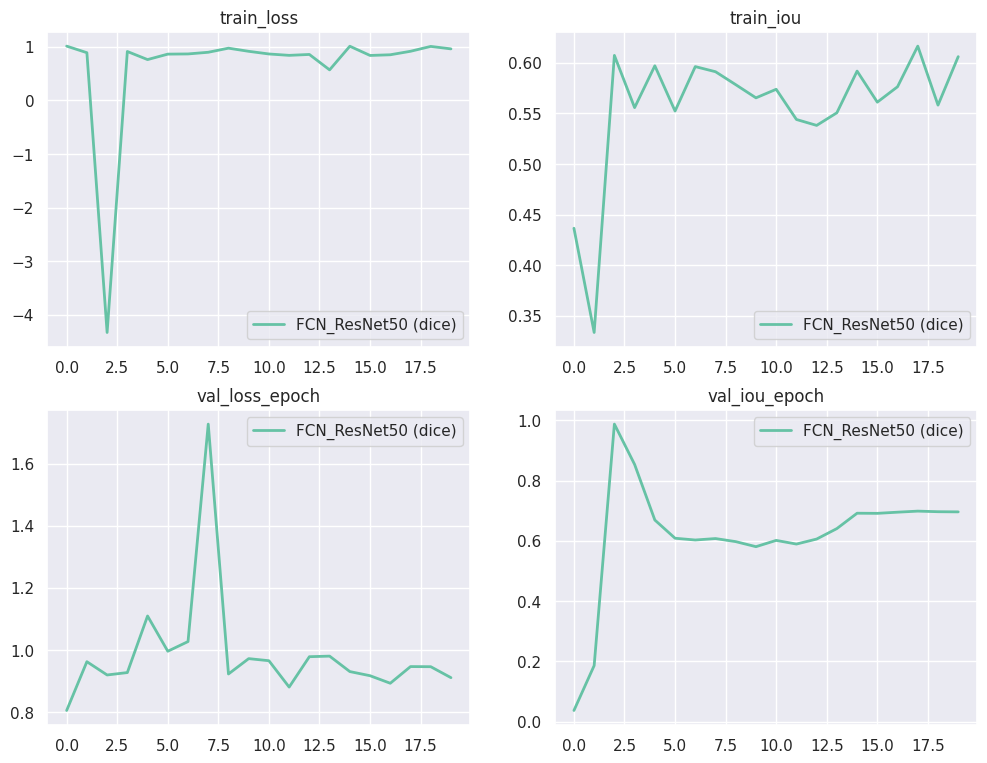

In [77]:
runs = wandb.Api().runs("segment_classification")
subplot_names = np.array([['train_loss', 'train_iou'],
                          ['val_loss_epoch', 'val_iou_epoch']])

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
lw = 2
for i, run in enumerate(runs):
    if 'dice' not in run.name:
        continue
        
    df = run.history().groupby('epoch').mean(numeric_only=True)
    for k in range(2):
        for m in range(2):
            axs[k, m].set_title(subplot_names[k, m])
            axs[k, m].plot(df[subplot_names[k, m]], lw=lw, label=run.name)
            axs[k, m].legend()


Судя по визуализации, чего больше у модели - False Negative или False Positive предсказаний?

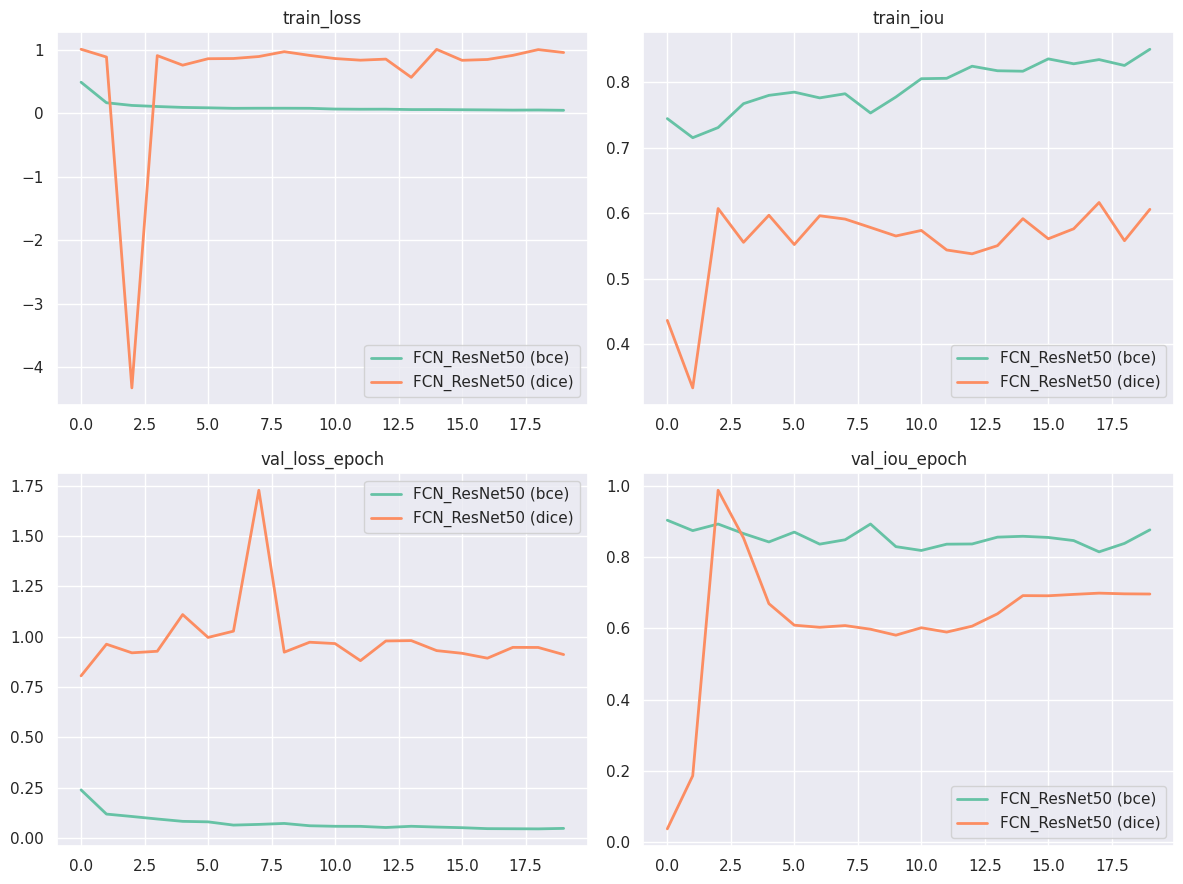

In [78]:
runs = wandb.Api().runs("segment_classification")
model_names = ['bce', 'dice']

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
for i, run in enumerate(runs):
    if 'bce' not in run.name and 'dice' not in run.name:
        continue

    df = run.history().groupby('epoch').mean(numeric_only=True)
        
    for k in range(2):
        for m in range(2):
            axs[k, m].set_title(subplot_names[k, m])
            axs[k, m].plot(df[subplot_names[k, m]], lw=lw,
                            label=f'{run.name}')
            axs[k, m].legend()
plt.tight_layout()

Высокий Dice Loss и низкий IoU на соответствующей модели указывают на то, значит модель плохо справляется с FN

#### Tversky Loss

Tversky Index является обобщением Dice Index для произвольных весов при FP и FN:

$$T_{\alpha, \beta} (y, \hat{y}) = \frac{\text{TP}}{\text{TP} + \alpha \ \text{FP} + \beta \ \text{FN}}$$

При этом $T_{\frac{1}{2}, \frac{1}{2}}$ соответсвует Dice Index; а $T_{1, 1} - $ Jaccard index (IoU).

Исходя из выводов про FN и FP подберите параметры $\alpha, \beta$ у Tversky Loss для модели. Обучите ее с таким лоссом. Улучшилась ли метрика? Как изменились предсказания визуально?

Надо увеличить бета -> берем $\alpha, \beta = 0.3, 0.7$

In [73]:
fcn_tversky = SegmentationModel(loss='tversky', alpha=0.3, beta=0.7)
wandb_logger = WandbLogger(project='segment_classification',
                           log_model='none',
                           name='FCN_ResNet50 Tversky')
trainer = pl.Trainer(max_epochs=20,
                     logger=wandb_logger,
                     log_every_n_steps=1)

trainer.fit(fcn_tversky, train_loader, val_loader)
wandb.finish()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | criterion | TverskyLoss        | 0      | train
1 | model     | FCN                | 35.3 M | train
2 | iou       | BinaryJaccardIndex | 0      | train
---------------------------------------------------------
35.3 M    Trainable params
0         Non-trainable params
35.3 M    Total params
141.289   Total estimated model params size (MB)
164       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                | 0/? [00:00…

Training: |                                                                                       | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

Validation: |                                                                                     | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=20` reached.


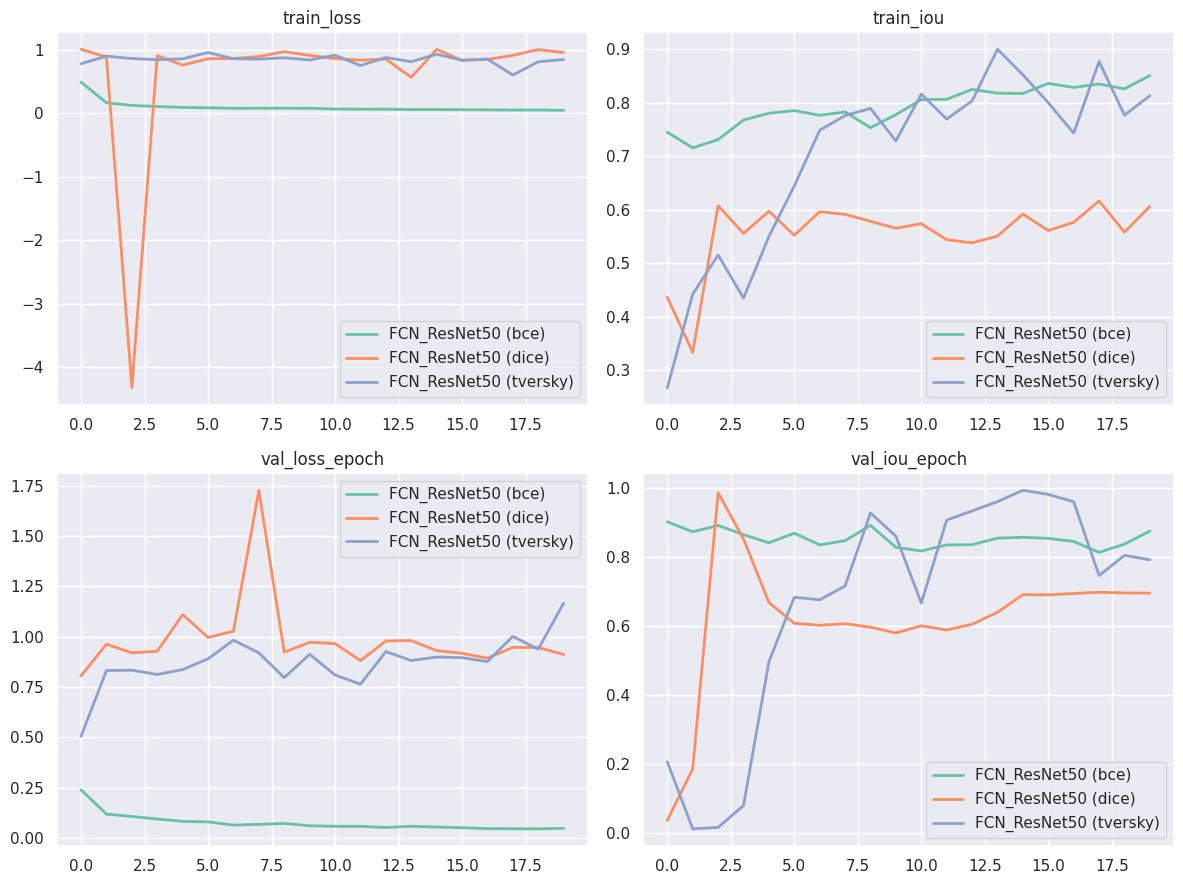

In [80]:
runs = wandb.Api().runs("segment_classification")

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
for i, run in enumerate(runs):

    df = run.history().groupby('epoch').mean(numeric_only=True)
        
    for k in range(2):
        for m in range(2):
            axs[k, m].set_title(subplot_names[k, m])
            axs[k, m].plot(df[subplot_names[k, m]], lw=lw,
                            label=f'{run.name}')
            axs[k, m].legend()
plt.tight_layout()

Из графиков видно, что tversky уверенно получил лучшую IoU на валидации, скачок dice скорее случаен и меньше по абсолютному значению (видно ниже) - мы улучшили выбором лосса модель

#### Визуализация логов обучения

Визуализируйте лосс и метрику на обучении и валидации на предыдущих запусках. Сравните и сделайте выводы, а также выводы по всей задаче.

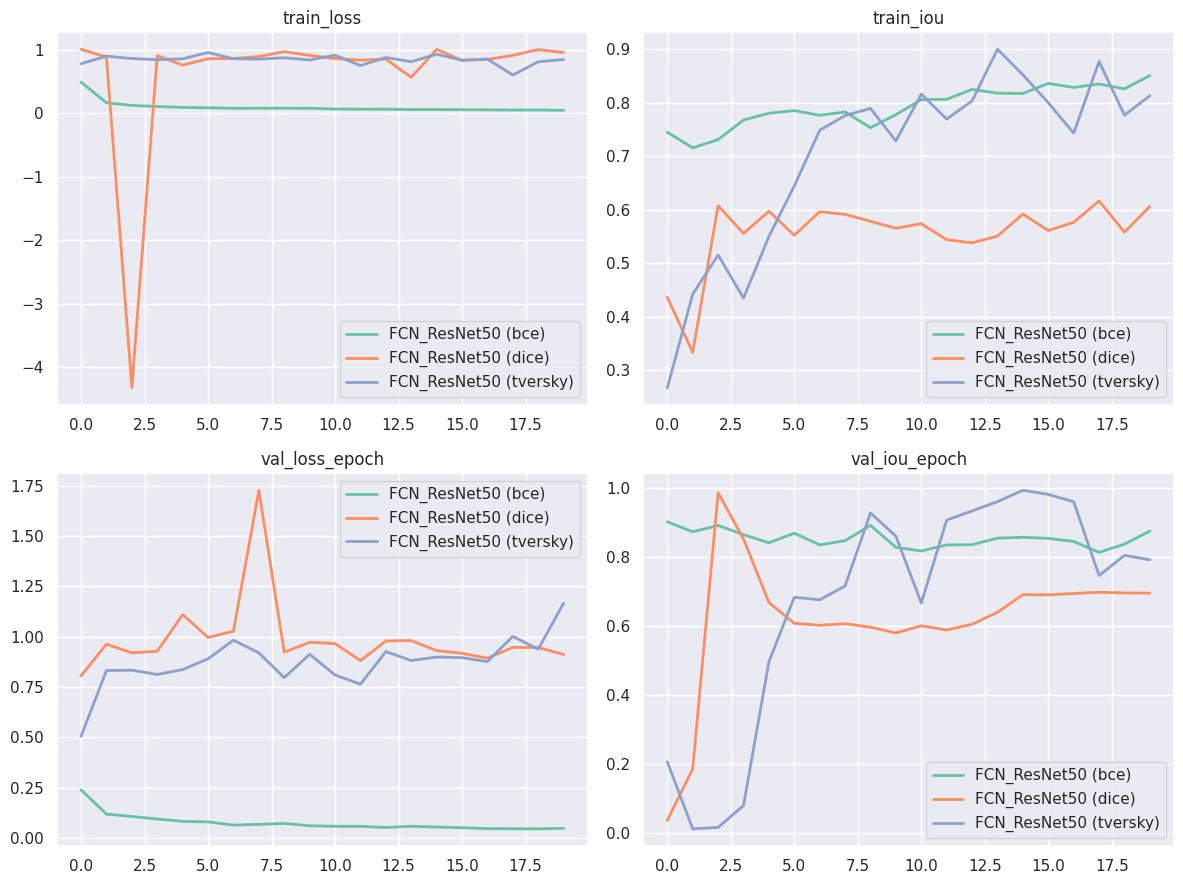

In [88]:
runs = wandb.Api().runs("segment_classification")

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
for i, run in enumerate(runs):

    df = run.history().groupby('epoch').mean(numeric_only=True)
        
    for k in range(2):
        for m in range(2):
            axs[k, m].set_title(subplot_names[k, m])
            axs[k, m].plot(df[subplot_names[k, m]], lw=lw,
                            label=f'{run.name}')
            axs[k, m].legend()
plt.tight_layout()

In [89]:
runs = wandb.Api().runs("segment_classification")

metrics = {}

for run in runs:
    df = run.history()
    max_iou = df['val_iou_epoch'].max()
    min_loss = df['val_loss_epoch'].min()
        
    metrics[run.name] = {
        'Max val_iou_epoch': round(max_iou, 4),
        'Min val_loss_epoch': round(min_loss, 4)
    }

metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
metrics_df.reset_index(inplace=True)
metrics_df.columns = ["Модель", "Максимум val_iou_epoch", "Минимум val_loss_epoch"]
metrics_df

Модель  Максимум val_iou_epoch  Минимум val_loss_epoch
0      FCN_ResNet50 (bce)                  0.9030                  0.0451
1     FCN_ResNet50 (dice)                  0.9871                  0.8055
2  FCN_ResNet50 (tversky)                  0.9943                  0.5051

**Выводы:**

Tversky Loss дает очень высокую метрику IoU, однако лосс всё ещё остаётся выше, чем у модели с BCE, модель всё ещё страдает от каких-то типов ошибок, по всей видимости, в контексте сложных или мелких объектов.

BCE и Tversky модели работают лучше всего по метрике IoU, при этом Tversky Loss более чувствителен к сбалансированности классов.

Dice Loss имеет отличный результат по IoU (скорее более случайный из характера графика), самые высокие значения лосса указывают на ошибки в предсказаниях.

Балансировкой лосса можно выбрать лучшую модель